# Определение возраста человека по фотографии

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель (свёрточную нейронную сеть), которая по фотографии определит приблизительный возраст человека.<br>
В нашем распоряжении набор фотографий людей и датасет с указанием названия изображения и возраста.

Требуется получить значения MAE на тестовой выборке не больше 8.

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table

In [2]:
constant = 12345

In [3]:
# для запуска из Colab чтобы был доступ к данным на Google-диск
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [4]:
path_1 = 'faces/'                                  # путь к исходным данным относительно тетради
path_2 = '../../22 computer vision/project/faces/' # альтернативный путь
path_3 = '/datasets/faces/'                        # путь для тренажёра
# путь для запуска тетради из Colab для доступа к данным на Google-диск
path_4 = '/content/drive/MyDrive/Data Science learning/project_age_by_face/faces/'

In [5]:
# перебираем разные варианты путей и сохраняем верный
for p in (path_1, path_2, path_3, path_4):
    try:
        labels = pd.read_csv(p+'labels.csv')
        path = p
        break
    except:
        pass

In [6]:
labels

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [8]:
def description(feature, title):
    '''По Series-признаку рисует диаграмму размаха, гистограмму и табличку с точным статистиками'''
    f, ax = plt.subplots(2,2, sharex=True, gridspec_kw={"height_ratios": (.15, .85), 
                                                        "width_ratios": (0.85, 0.15)}, figsize=(9,3.5))
    sns.boxplot(x=feature, ax=ax[0,0])
    sns.histplot(x=feature, bins=100, ax=ax[1,0], element="step",alpha=0.3)
    ax[0,1].remove()
    table(data=feature.describe(), ax=ax[1,1], loc='right',colWidths=[1.8])
    
    ax[0,0].set(yticks=[], xlabel=None)
    sns.despine(ax=ax[1,0])
    sns.despine(ax=ax[0,0], left=True)
    plt.axis('off')
    f.suptitle(title)

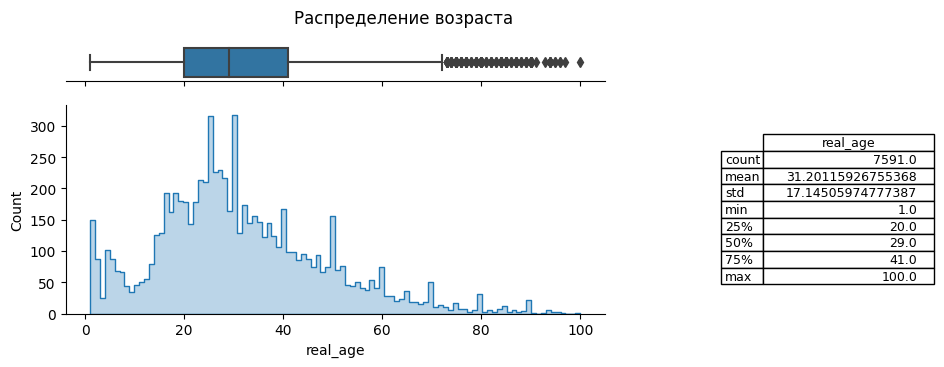

In [9]:
description(labels['real_age'], 'Распределение возраста')

In [10]:
# создание дополнительных столбцов с информацией об изображениях
def file_characteristics(file):
    im = Image.open(path + 'final_files/' + file)
    return im.size, im.mode, im.format

labels[['size', 'mode', 'format']] = pd.DataFrame(labels['file_name'].\
                                                  apply(lambda x: file_characteristics(x)).tolist())

In [11]:
labels.head()

,file_name,real_age,size,mode,format
0,000000.jpg,4,"(114, 114)",RGB,JPEG
1,000001.jpg,18,"(784, 784)",RGB,JPEG
2,000002.jpg,80,"(133, 133)",RGB,JPEG
3,000003.jpg,50,"(370, 370)",RGB,JPEG
4,000004.jpg,17,"(212, 212)",RGB,JPEG


In [12]:
labels['mode'].unique()                    # цветовые режимы в датасете

array(['RGB'], dtype=object)

In [13]:
labels['format'].unique()                  # форматы в датасете

array(['JPEG'], dtype=object)

In [14]:
labels['size'].nunique()                   # количество уникальных размеров изображений в датасете

2293

In [15]:
labels['size'].value_counts().head(10)     # топ-10 самых популярных размеров в датасете

(517, 517)    37
(165, 165)    37
(166, 166)    31
(331, 331)    28
(257, 257)    27
(434, 434)    27
(184, 184)    24
(190, 190)    23
(355, 355)    22
(251, 251)    22
Name: size, dtype: int64

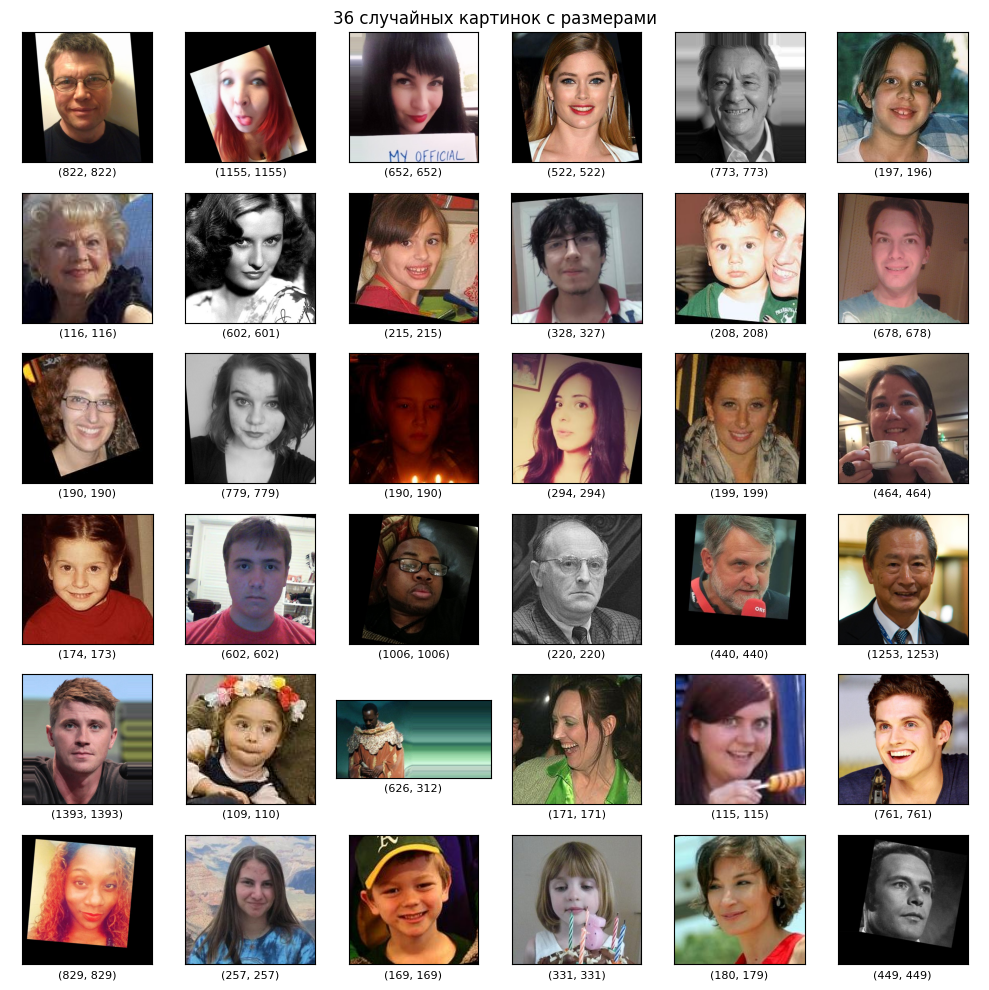

In [16]:
fig = plt.figure(figsize=(10,10))
plt.title('36 случайных картинок с размерами'); plt.axis('off')

for i in range(36):
    fig.add_subplot(6, 6, i+1)
    random_image = labels['file_name'].sample().item()
    plt.imshow(Image.open(path + '/final_files/' + random_image))
    plt.xlabel(labels.query('file_name == @random_image')['size'].item(), fontsize=8)
    plt.xticks([]); plt.yticks([]); plt.tight_layout()

<a id= 'EDA'></a>
## Вывод по анализу данных

* Исходный датасет в количестве 7591 изображение.
* Все изображения в формате JPEG и в цветовом режиме RGB.
* Изображения разных размеров; самые популярные, пкс: (517, 517), (165, 165), (166, 166), (331, 331), (257, 257).
* Медианный возраст людей на картинках - 29 лет, средний - 31.
* Возрастное распределение близко к нормальному. Виден спад в возрасте около 10 лет.

## Machine Learning

In [17]:
datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

In [18]:
def load_train(path):
    '''создаёт обучающую выборку'''
    train_datagen_flow = datagen.flow_from_dataframe(
        pd.read_csv(path+'labels.csv'),
        path+'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        batch_size=32,
        target_size=(150, 150),
        subset='training',
        seed=constant)
    return train_datagen_flow

In [19]:
def load_test(path):
    '''создаёт тестовую выборку'''
    test_datagen_flow = datagen.flow_from_dataframe(
        pd.read_csv(path+'labels.csv'),
        path+'final_files',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        batch_size=32,
        target_size=(150, 150),
        subset='validation',
        seed=constant)
    return test_datagen_flow

In [20]:
train_datagen_flow = load_train(path)
test_datagen_flow  = load_test (path)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


In [21]:
def create_model(input_shape):
    '''создаёт модель машинного обучения'''
    backbone = ResNet50(input_shape = input_shape,
                        weights = 'imagenet',
                        include_top = False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse',
                  metrics=['mae'])

    return model

In [22]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    '''обучает модель'''
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, 
              shuffle=True)
    return model

In [23]:
model = create_model((150,150,3))
train_model(model, train_datagen_flow, test_datagen_flow)

Epoch 1/10
178/178 - 496s - loss: 280.2023 - mae: 12.0655 - val_loss: 908.5496 - val_mae: 25.3098 - 496s/epoch - 3s/step
Epoch 2/10
178/178 - 495s - loss: 72.0570 - mae: 6.4605 - val_loss: 824.4387 - val_mae: 23.7648 - 495s/epoch - 3s/step
Epoch 3/10
178/178 - 502s - loss: 36.9148 - mae: 4.6682 - val_loss: 266.5388 - val_mae: 12.1943 - 502s/epoch - 3s/step
Epoch 4/10
178/178 - 497s - loss: 24.2017 - mae: 3.7673 - val_loss: 116.5244 - val_mae: 8.1697 - 497s/epoch - 3s/step
Epoch 5/10
178/178 - 498s - loss: 20.3434 - mae: 3.4558 - val_loss: 114.8538 - val_mae: 8.4816 - 498s/epoch - 3s/step
Epoch 6/10
178/178 - 499s - loss: 17.4455 - mae: 3.2377 - val_loss: 116.3567 - val_mae: 8.6879 - 499s/epoch - 3s/step
Epoch 7/10
178/178 - 500s - loss: 16.7794 - mae: 3.1453 - val_loss: 87.3654 - val_mae: 6.9519 - 500s/epoch - 3s/step
Epoch 8/10
178/178 - 498s - loss: 15.5876 - mae: 3.0088 - val_loss: 80.1895 - val_mae: 6.5990 - 498s/epoch - 3s/step
Epoch 9/10
178/178 - 497s - loss: 11.9793 - mae: 2.63

## Вывод

* Заключение по анализу данных выше в разделе [Вывод по анализу данных](#EDA).
* Построена модель на основе свёрточной нейронной сети ResNet50. <br>
Лучшее значение MAE = 6.5763 достигнуто на тестовой выборке  на 10-ой эпохе с оптимизатором Adam при learning_rate 0.0001. В батче по 32 объекта.
* Также были проведены эксперименты с той же архитектурой, но с другими значениями learning_rate.<br>
Результаты на 10-ой эпохе:<br>
lr=0.01, MAE=11.9246<br>
lr=0.001, MAE=7.4705